# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Project F: Measuring the Shape and Brightness of Galaxies with Neural Networks
### Milestone 2: Exploratory Data Analysis
### Group 75: Dmitry Vukolov, Ning Xu, Rohit Beri, Sunil Chomal


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>


<hr style="height:2pt">

---



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
                     ).text
HTML(styles)

---

<div class="theme"> Overview </div> 

We a

In [41]:
# Load useful libraries
import os
import sys
import copy 
import math
import time
import random 
import numpy as np
import pandas as pd
import ipywidgets as widgets

# Import h5py for reading h5 files
import h5py

# Load glasim for data generation
import galsim

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

np.set_printoptions(threshold=sys.maxsize)

## <div class='exercise'> <b> Question 2: Set-up an AutoEncoder [20 points] </b> </div>

**Define**

We es.

In [3]:
# Read the data set
f= h5py.File('./data/Data1.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
psf = f['psf_r'][:]
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()

In [4]:
# Data Size
print('Image Shape            = {}'.format(image.shape))
print('No-noise Image Shape   = {}'.format(image_nonoise.shape))
print('With-noise Image Shape = {}'.format(image_withnoise.shape))
print('Cat Shape              = {}'.format(cat.shape))
print('Label Shape            = {}'.format(label.shape))
print('SNR Shape              = {}'.format(snr.shape))
print('Sigma Shape            = {}'.format(sigma.shape))
print('PSF-R Shape            = {}'.format(psf.shape))

Image Shape            = (18779, 64, 64)
No-noise Image Shape   = (18779, 64, 64)
With-noise Image Shape = (18779, 64, 64)
Cat Shape              = (18779, 6, 64, 64)
Label Shape            = (18779, 5)
SNR Shape              = (18779,)
Sigma Shape            = (18779,)
PSF-R Shape            = (20000,)


In [5]:
print('Image Data:            Max = {:8.2f}  and  Min = {:8.2f}'.format(image.max(), image.min()))
print('No-noise Image Data:   Max = {:8.2f}  and  Min = {:8.2f}'.format(image_nonoise.max(), image_nonoise.min()))
print('With-noise Image Data: Max = {:8.2f}  and  Min = {:8.2f}'.format(image_withnoise.max(), image_withnoise.min()))

print('\n')

print('Cat Data - Process 0:  Max = {:8.2f}  and  Min = {:8.2f}'.format(cat[:,0].max(), cat[:,0].min()))
print('Cat Data - Process 1:  Max = {:8.2f}  and  Min = {:8.2f}'.format(cat[:,1].max(), cat[:,1].min()))
print('Cat Data - Process 2:  Max = {:8.2f}  and  Min = {:8.2f}'.format(cat[:,2].max(), cat[:,2].min()))
print('Cat Data - Process 3:  Max = {:8.2f}  and  Min = {:8.2f}'.format(cat[:,3].max(), cat[:,3].min()))
print('Cat Data - Process 4:  Max = {:8.2f}  and  Min = {:8.2f}'.format(cat[:,4].max(), cat[:,4].min()))
print('Cat Data - Process 5:  Max = {:8.2f}  and  Min = {:8.2f}'.format(cat[:,5].max(), cat[:,5].min()))

print('\n')

print('SNR Data:              Max = {:8.2f}  and  Min = {:8.2f}'.format(snr.max(), snr.min()))
print('Sigma Data:            Max = {:8.2f}  and  Min = {:8.2f}'.format(sigma.max(), sigma.min()))
print('PSF-R Data:            Max = {:8.2f}  and  Min = {:8.2f}'.format(psf.max(), psf.min()))

print('\n')

print('Label-flux:            Max = {:8.2f}  and  Min = {:8.2f}'.format(label[:,0].max(), label[:,0].min()))
print('Label-sersic index:    Max = {:8.2f}  and  Min = {:8.2f}'.format(label[:,1].max(), label[:,1].min()))
print('Label-sersic radius:   Max = {:8.2f}  and  Min = {:8.2f}'.format(label[:,2].max(), label[:,2].min()))
print('Label-g1:              Max = {:8.2f}  and  Min = {:8.2f}'.format(label[:,3].max(), label[:,3].min()))
print('Label-g2:              Max = {:8.2f}  and  Min = {:8.2f}'.format(label[:,4].max(), label[:,4].min()))

Image Data:            Max =    36.95  and  Min =    -5.47
No-noise Image Data:   Max = 13615.28  and  Min =    -0.13
With-noise Image Data: Max = 14236.50  and  Min = -1950.24


Cat Data - Process 0:  Max =    36.95  and  Min =    -5.47
Cat Data - Process 1:  Max =   965.49  and  Min =     0.00
Cat Data - Process 2:  Max =    12.91  and  Min =    -4.87
Cat Data - Process 3:  Max =  3345.63  and  Min = -1772.62
Cat Data - Process 4:  Max =     7.64  and  Min =     0.00
Cat Data - Process 5:  Max =    58.40  and  Min =     0.00


SNR Data:              Max =   100.00  and  Min =     9.99
Sigma Data:            Max =   400.00  and  Min =   200.00
PSF-R Data:            Max =     1.00  and  Min =     0.50


Label-flux:            Max =     4.10  and  Min =     0.30
Label-sersic index:    Max =     6.00  and  Min =     0.50
Label-sersic radius:   Max =     0.60  and  Min =     0.10
Label-g1:              Max =     0.67  and  Min =    -0.67
Label-g2:              Max =     0.67  and  Min = 

In [6]:
np.random.seed(42)
idx = np.random.randint(image.shape[0], size=16)
print(idx)

[15795   860  5390 11964 11284  6265 16850  4426 14423 11363 16023  8322
  1685   769  2433  5311]


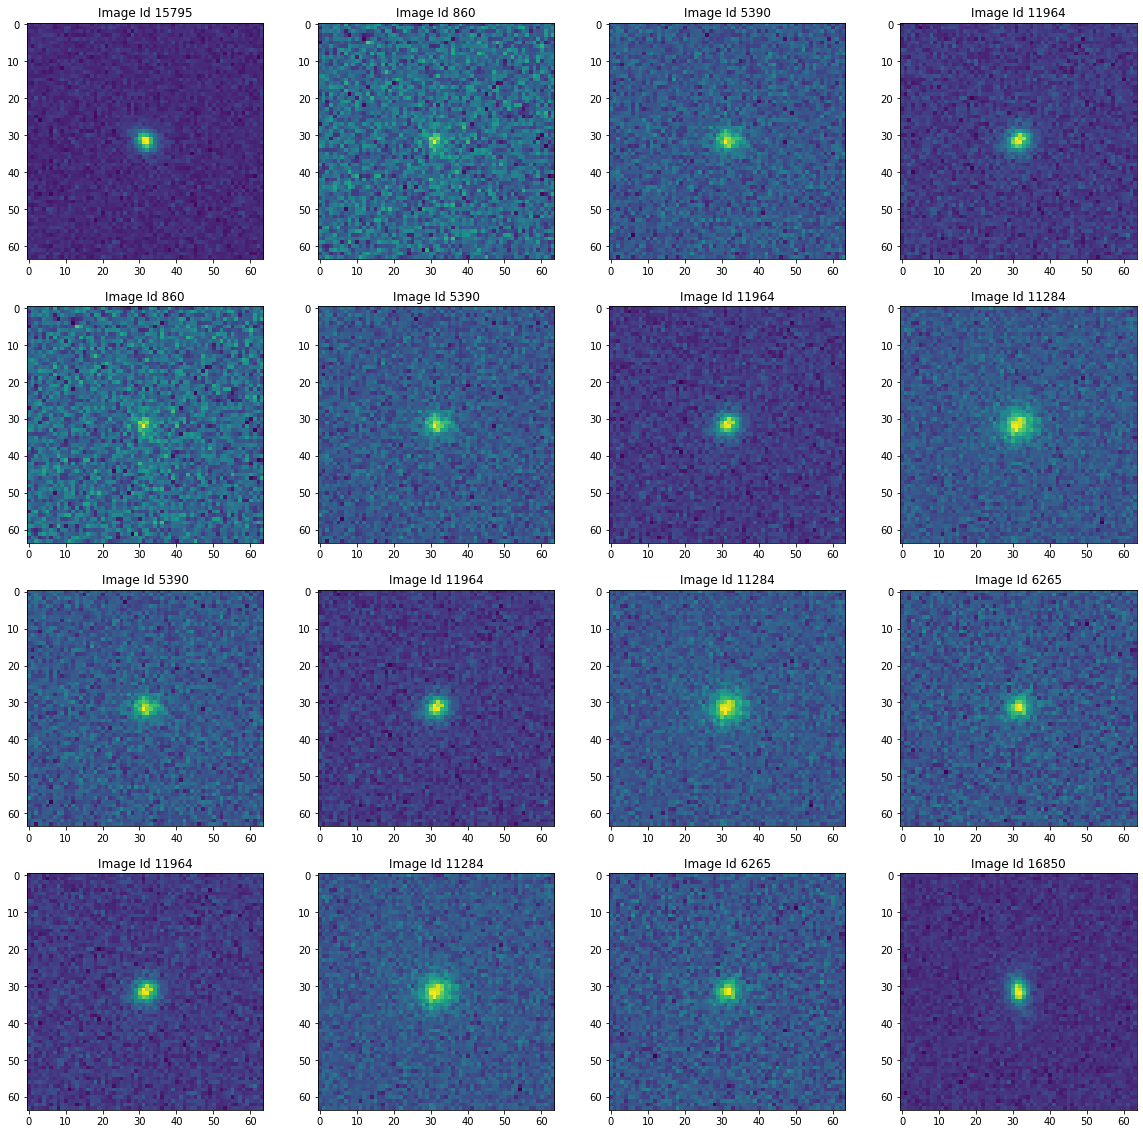

In [33]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(image[idx[i+j]])
        ax[i,j].set_title('Image Id {}'.format(idx[i+j]))

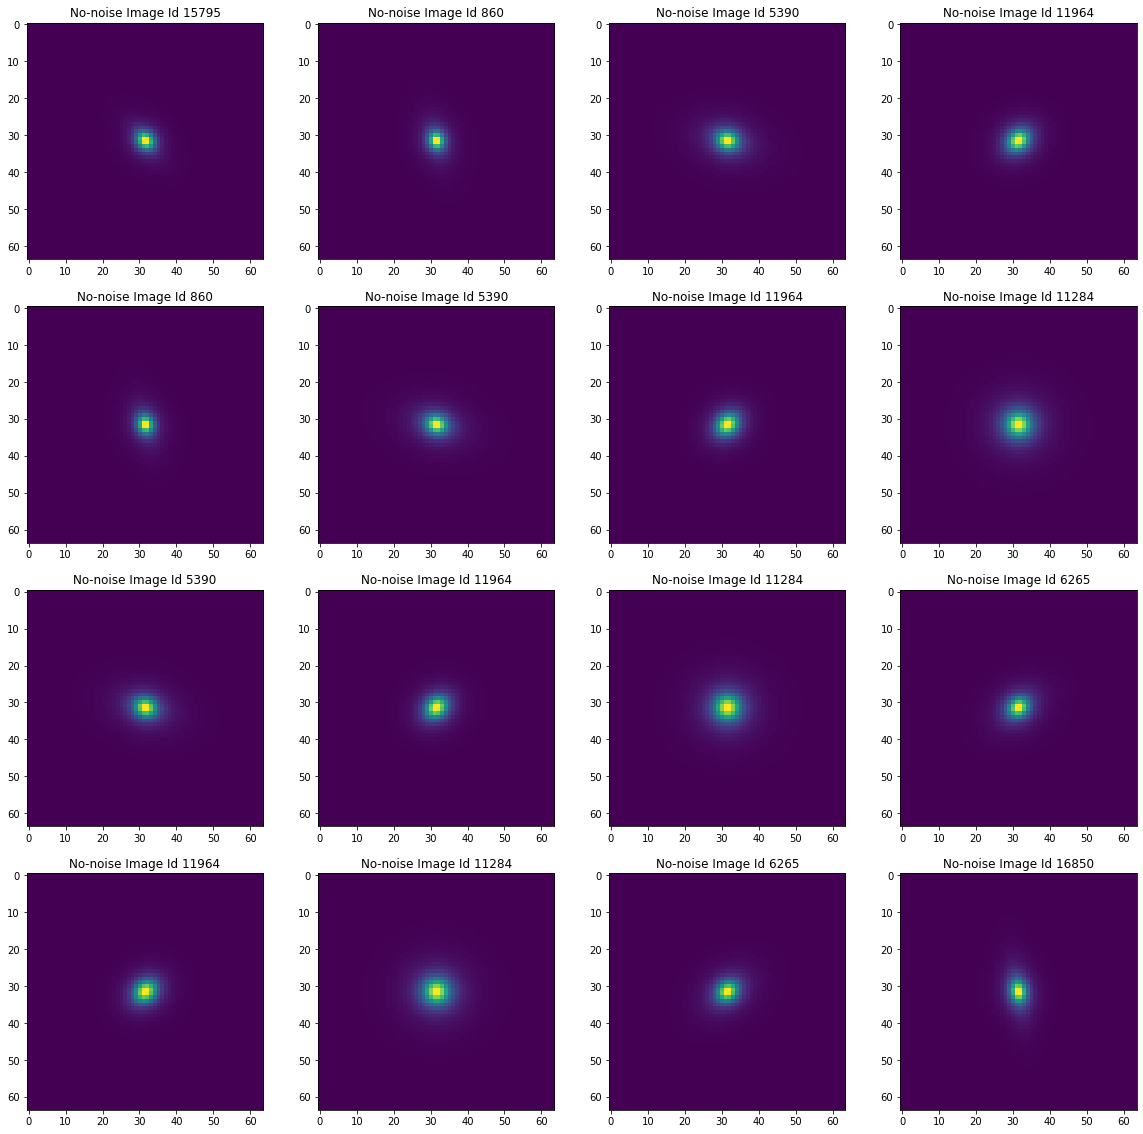

In [8]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(image_nonoise[idx[i+j]])
        ax[i,j].set_title('No-noise Image Id {}'.format(idx[i+j]))

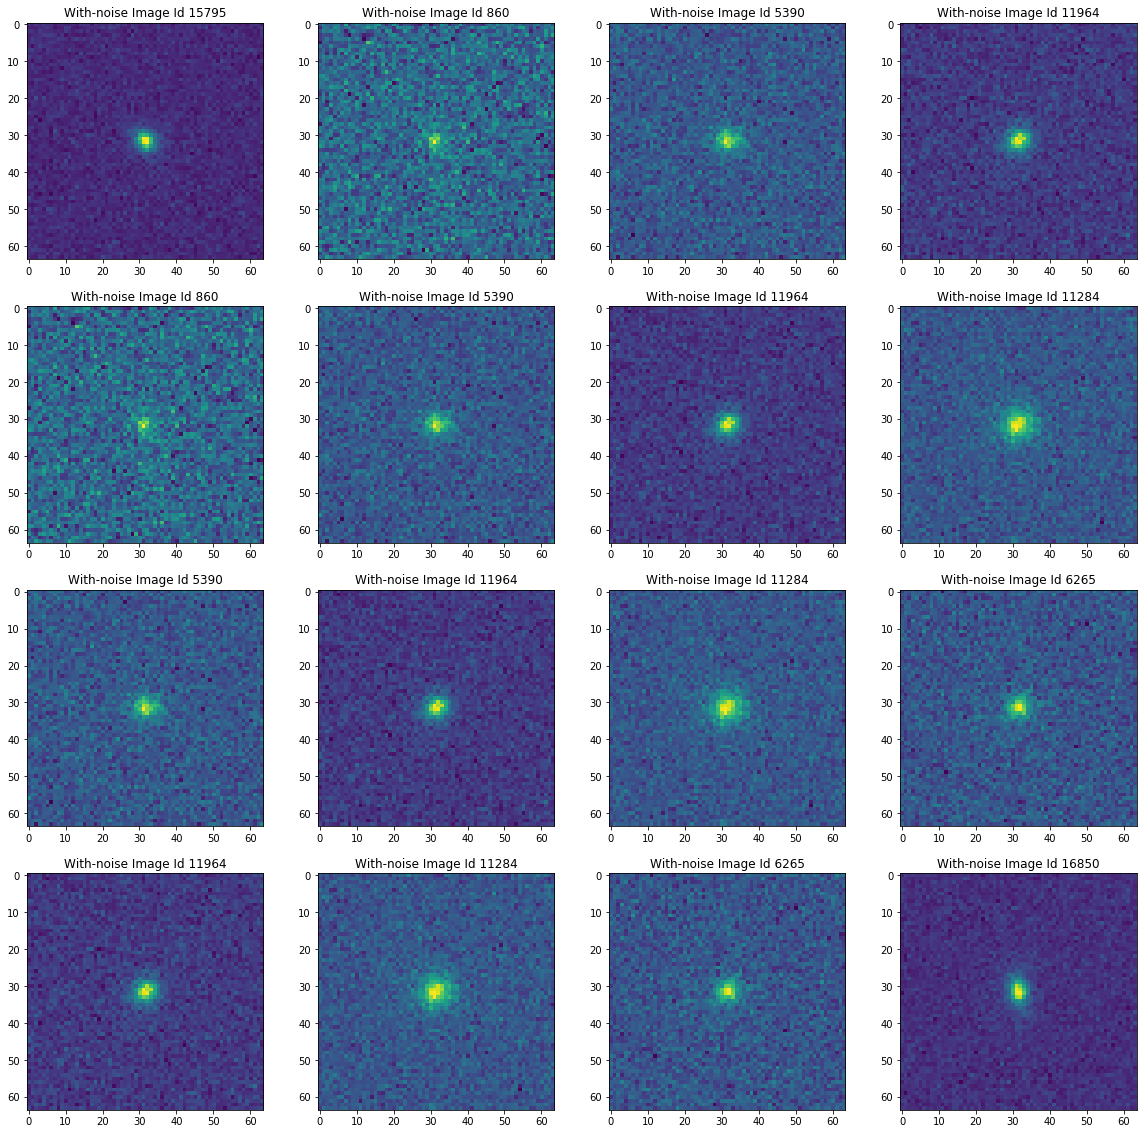

In [9]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(image_withnoise[idx[i+j]])
        ax[i,j].set_title('With-noise Image Id {}'.format(idx[i+j]))

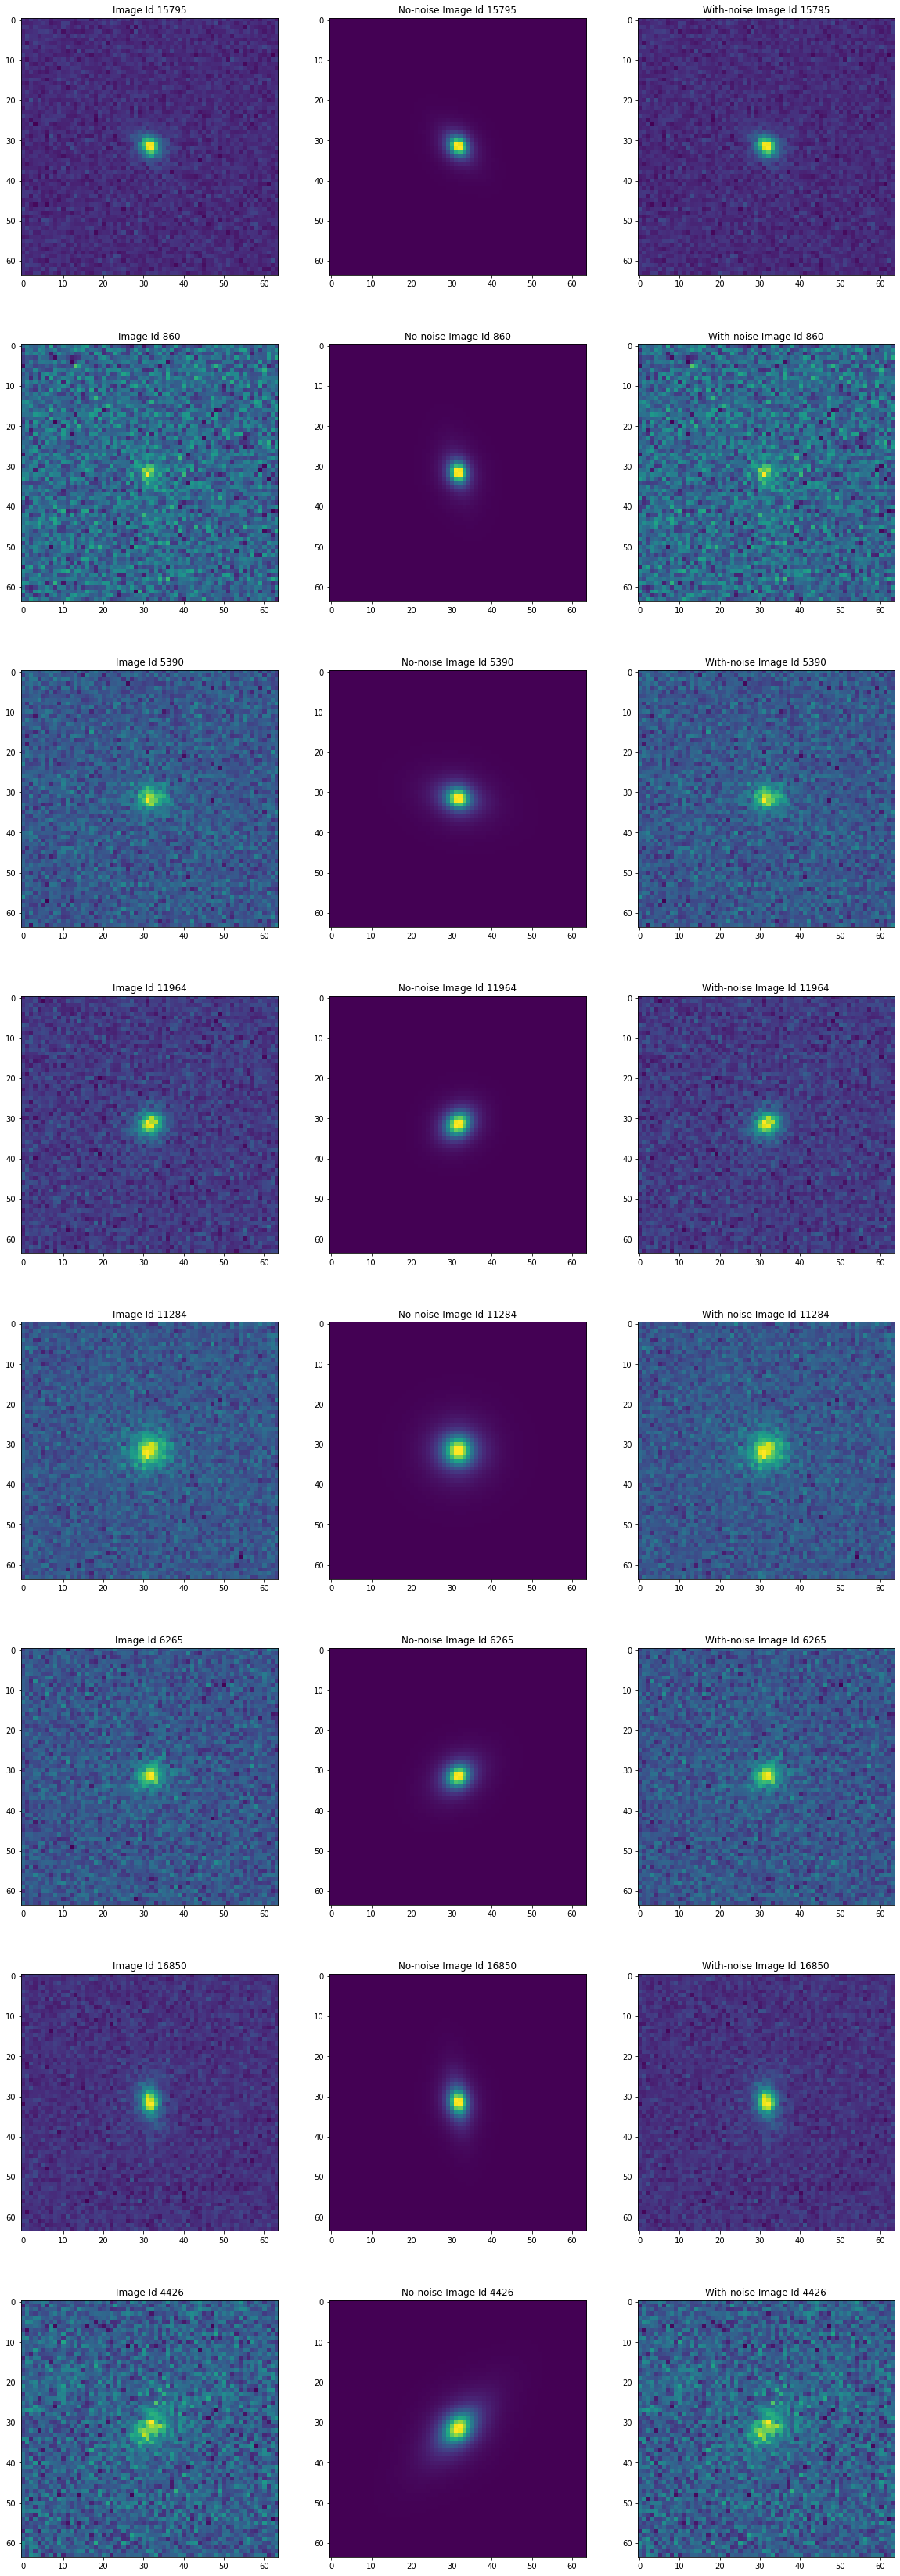

In [10]:
fig, ax = plt.subplots(8,3, figsize=(20,60))
for i in range(8):
    ax[i,0].imshow(image[idx[i]])
    ax[i,0].set_title('Image Id {}'.format(idx[i]))
    ax[i,1].imshow(image_nonoise[idx[i]])
    ax[i,1].set_title('No-noise Image Id {}'.format(idx[i]))
    ax[i,2].imshow(image_withnoise[idx[i]])
    ax[i,2].set_title('With-noise Image Id {}'.format(idx[i]))

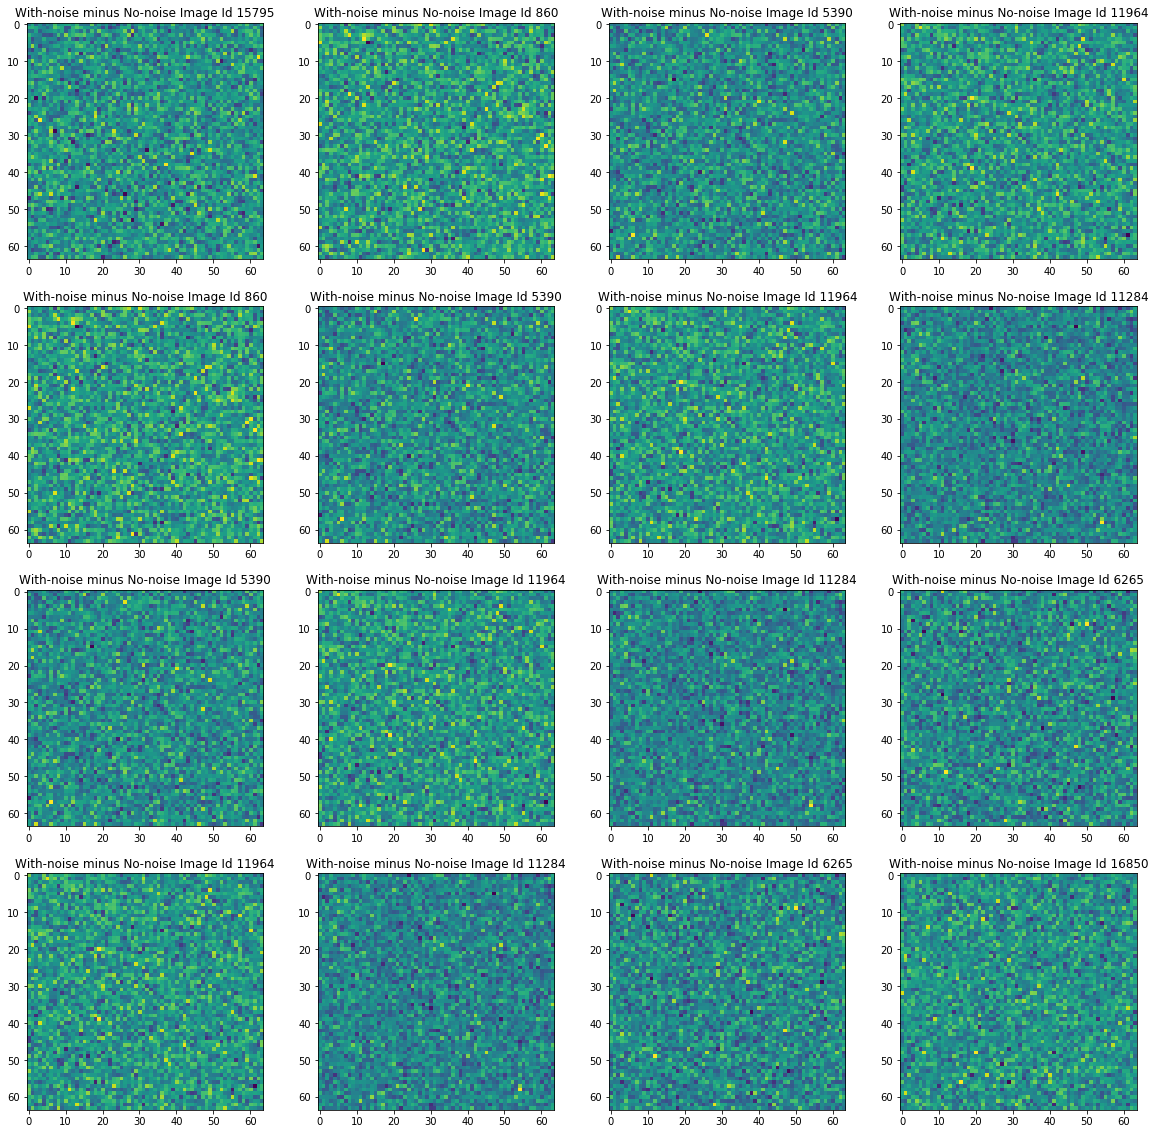

In [11]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        img = -(image_withnoise[idx[i+j]] - image_nonoise[idx[i+j]])
        ax[i,j].imshow(img)
        ax[i,j].set_title('With-noise minus No-noise Image Id {}'.format(idx[i+j]))

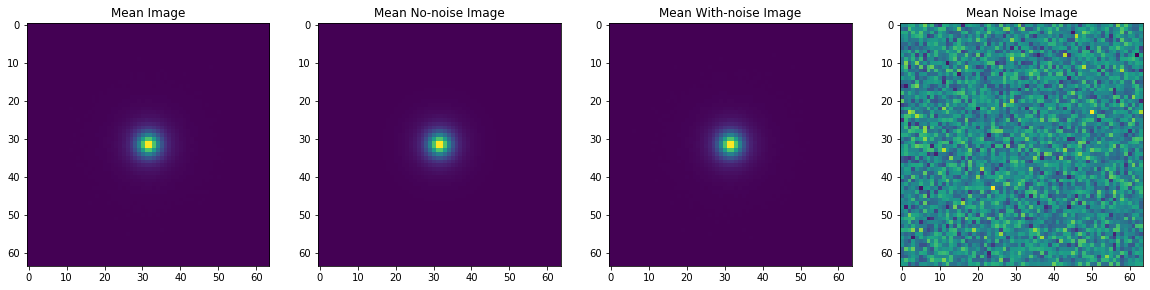

In [12]:
noise = image_withnoise - image_nonoise

fig, ax = plt.subplots(1,4, figsize=(20,10))

ax[0].imshow(image.mean(axis=0))
ax[0].set_title('Mean Image')
ax[1].imshow(image_nonoise.mean(axis=0))
ax[1].set_title('Mean No-noise Image')
ax[2].imshow(image_withnoise.mean(axis=0))
ax[2].set_title('Mean With-noise Image')
ax[3].imshow(noise.mean(axis=0))
ax[3].set_title('Mean Noise Image')

plt.show()

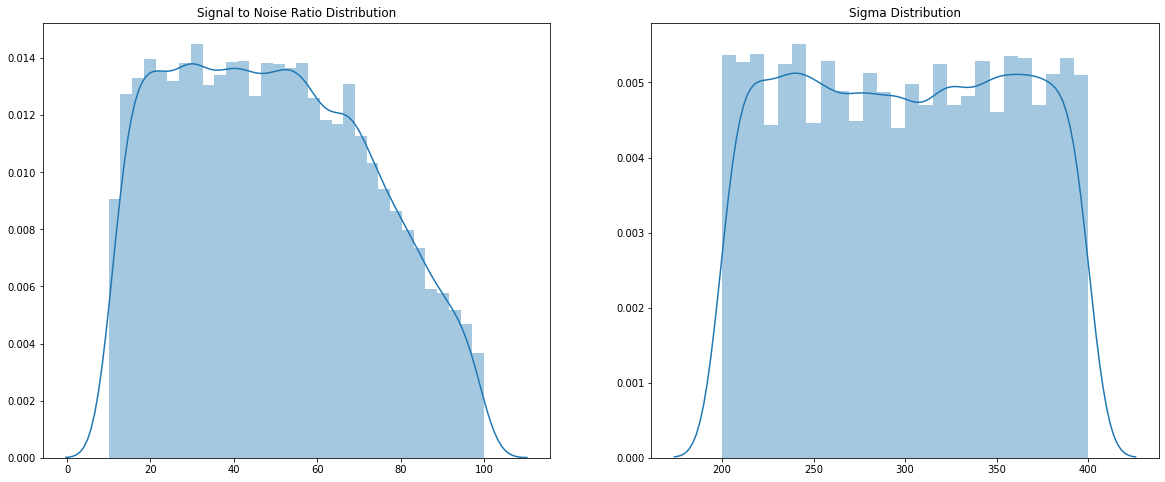

In [13]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(snr).set(title='Signal to Noise Ratio Distribution')
plt.subplot(1,2,2)
ax[1] = sns.distplot(sigma).set(title='Sigma Distribution')
plt.show()

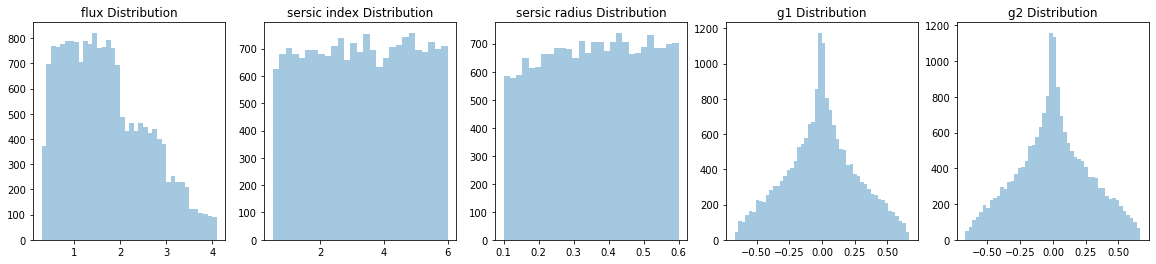

In [34]:
labels = ['flux', 'sersic index', 'sersic radius', 'g1', 'g2']

plt.figure(figsize=(20,4))

for i in range(5):
    plt.subplot(1,5,i+1)
    sns.distplot(label[:,i], kde=False).set(title='{} Distribution'.format(labels[i]))
plt.show()

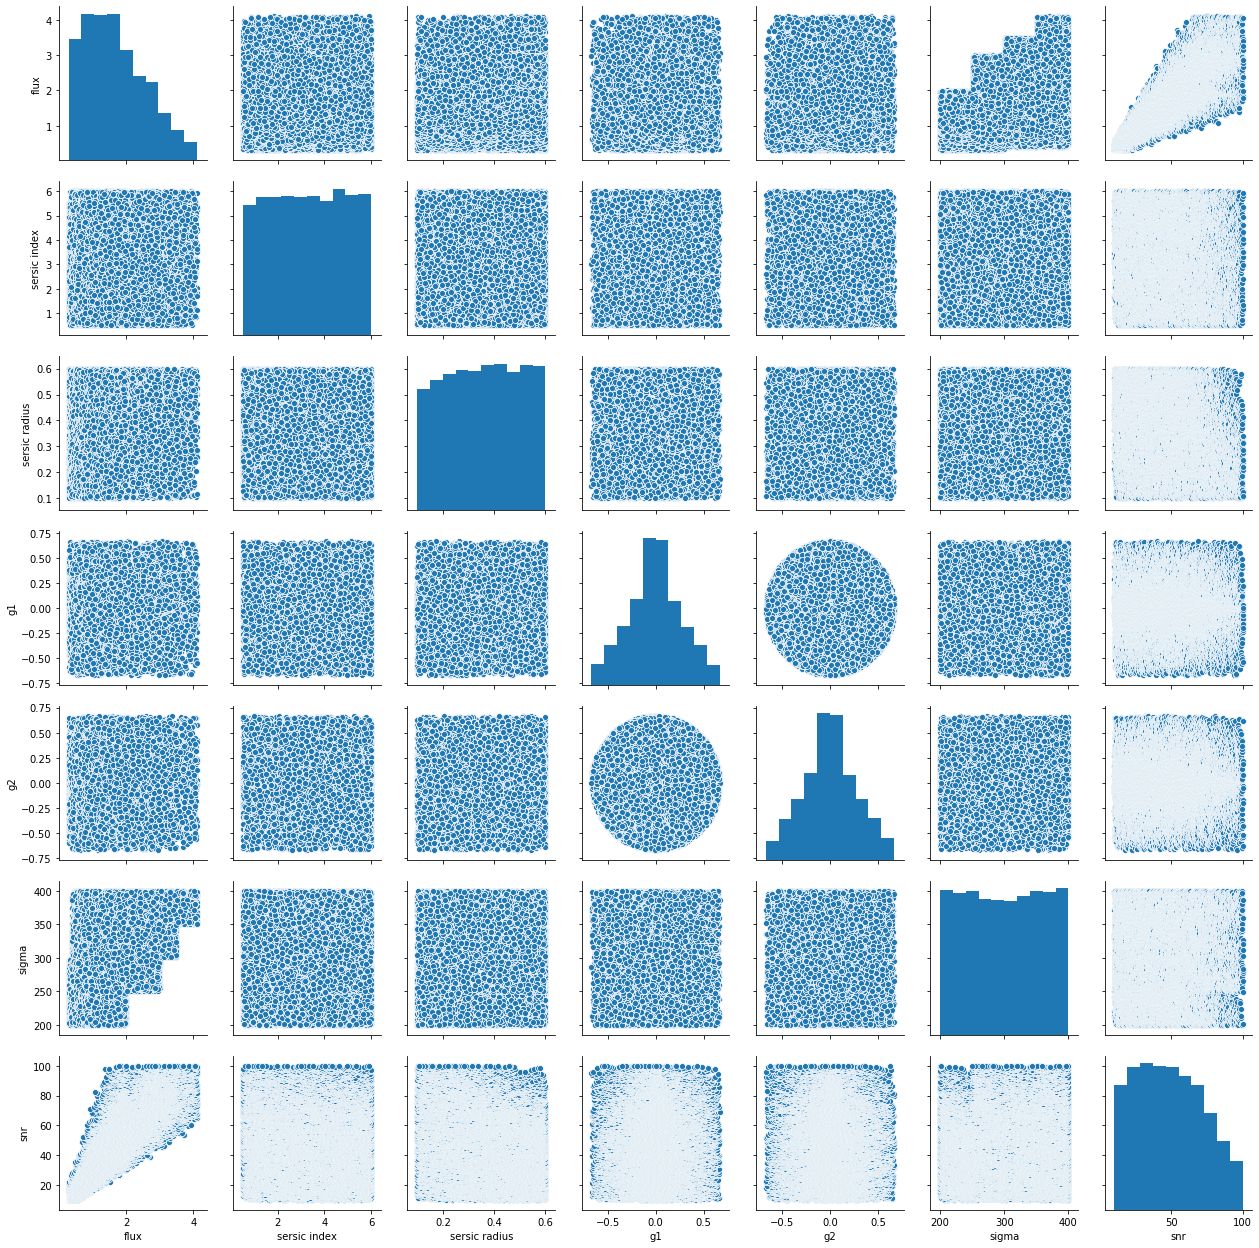

In [20]:
label_df = pd.DataFrame(label, columns=labels)
label_df['sigma'] = sigma
label_df['snr'] = snr

sns.pairplot(label_df)
plt.show()

In [56]:
def plot_galaxies(psf_re=random.uniform(0.5,1),
                  bulge_re=random.uniform(0.1,0.6),
                  bulge_n=random.uniform(0.5,6),
                  A=random.uniform(0,0.67),
                  gal_beta = random.uniform(0,3.14),
                  noise= random.randint(200,400),
                  gal_flux = 1e5*random.uniform(.3,4)
                 ):
    """
    
    Parameter random generations or supplied values
    
    psf_re:   PSF moffat scale radius in arcsec 
    bulge_re: sersic radius, unit arcsec
    bulge_n:  sersic index
    A: gal_q: b/a will ranges in (0.2,1) & A=1-q / 1+q
    gal_beta: radians 
    noise:    sigma proportional to inverse of SNR
    gal_flux: flux i.e. spectral intensity
    
    """
    size = 1
    img_nonoise_ = np.zeros((size,64,64))

    image_size = 64                      # n x n pixels
    pixel_scale = 0.23                   # arcsec / pixel
    random_seed = 1314662
    rng = galsim.BaseDeviate(random_seed+1)
    psf_beta = 2                         #moffat parameter   


    # q is ellipticity and beta is orientation. 
    # You could directly predict q and beta but there would be a discontiniuty issue for beta. 
    # A jump from 180 degree to 1 degree. 
    # radial sampling for g1 and g2 -reduced shear -> ellipticiy and orientation 
    # gal_q =b/a will ranges in (0.2,1) & A=1-q / 1+q 
    gal_q=(1- A ) /(1+ A )      
    g_1=A *np.cos(2*gal_beta)
    g_2=A *np.sin(2*gal_beta)


    gal = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
    gal = gal.withFlux(gal_flux )
    gal = gal.shear(g1=g_1,g2=g_2)
    psf = galsim.Moffat(beta=psf_beta, flux=1., fwhm=psf_re)   
    final = galsim.Convolve([psf, gal])
    image1 = galsim.ImageF(image_size, image_size,scale=pixel_scale)
    final.drawImage(image=image1);
    image_nonoise1 = copy.deepcopy(image1.array)
    
    #signal to noise ratio, after generating data, choose data with snr [10,100]
    snr1=np.sqrt((image1.array**2).sum())/noise 

    image1.addNoise(galsim.PoissonNoise(sky_level=0.))   
    noisemap = np.random.normal(0, noise, 64*64)  #noise map for bkgr gaussian noise 
    noisemap = noisemap.reshape((64,64))
    
    #you can also use add noise to add gaussian noise by using 'image.addNoise(galsim.GaussianNoise(sigma=noise))' 
    img_fv = image1.array+noisemap   

    final_2 = psf 
    image_2 = galsim.ImageF(image_size, image_size,scale=pixel_scale)
    final_2.drawImage(image=image_2) 

    img_ = img_fv # final noised image 
    img_2_ = image_2.array  # psf 

    plt.figure(figsize=(20,8))
    ax = plt.subplot(1,3,1)
    plt.imshow(image_nonoise1) # image without noise 
    ax.set_title('image without noise')
    ax = plt.subplot(1,3,2)
    plt.imshow(img_)  # final image 
    ax.set_title('final image')
    ax = plt.subplot(1,3,3)
    plt.imshow(img_2_)  # psf
    ax.set_title('psf')
    plt.show()

In [62]:
psf_re = widgets.FloatSlider(min=0.5, max=1, step=0.05, description='PSF', continuous_update=False)
bulge_re = widgets.FloatSlider(min=0.1, max=0.6, step=0.05, description='Sersic Radius', continuous_update=False)
bulge_n = widgets.FloatSlider(min=0.5, max=6, step=0.5, description='Sersic Index', continuous_update=False)
A = widgets.FloatSlider(min=0, max=0.67, step=0.067, description='Ellipticity', continuous_update=False)
gal_beta = widgets.FloatSlider(min=0, max=3.14, step=0.314, description='Orientation', continuous_update=False)
noise = widgets.IntSlider(min=200, max=400, step=20, description='Noise', continuous_update=False)
gal_flux = widgets.FloatSlider(min=0.3, max=4, step=0.37, description='Flux', continuous_update=False)

input = {'psf_re': psf_re,
         'bulge_re': bulge_re,
         'bulge_n': bulge_n,
         'A': A,
         'gal_beta': gal_beta,
         'noise': noise,
         'gal_flux': gal_flux
        }

ui = widgets.VBox([psf_re, bulge_re, bulge_n, A, gal_beta, noise, gal_flux])
out = widgets.interactive_output(plot_galaxies, input)

display(ui, out)

Output()

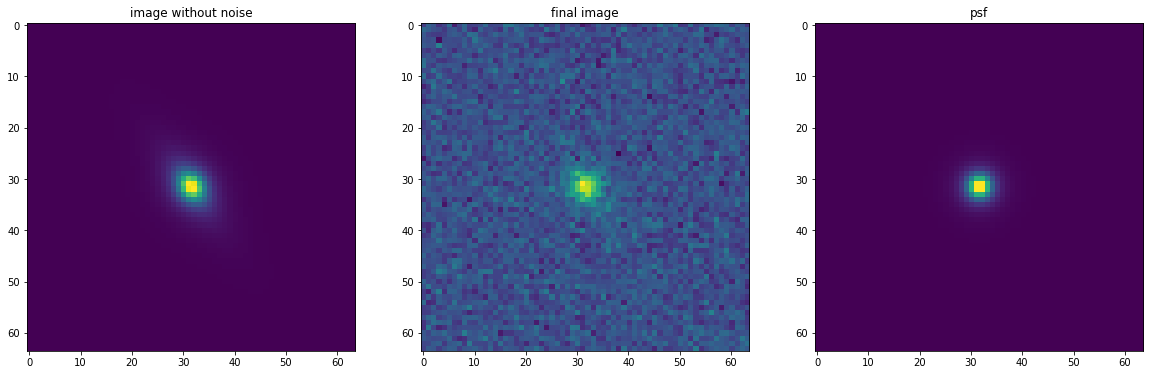

In [40]:
# fixed parameters 

np.random.seed(123)
size = 1
img_nonoise_ = np.zeros((size,64,64))

image_size = 64                      # n x n pixels
pixel_scale = 0.23                   # arcsec / pixel
random_seed = 1314662
rng = galsim.BaseDeviate(random_seed+1)
psf_beta = 2                         #moffat parameter 


#parameter random generations  
psf_re=random.uniform(0.5,1)         # PSF moffat scale radius in arcsec 
bulge_re = random.uniform(0.1,0.6)   # sersic radius, unit arcsec
bulge_n = random.uniform(0.5,6)      # sersic index 

# q is ellipticity and beta is orientation. 
#You could directly predict q and beta but there would be a discontiniuty issue for beta. A jump from 180 degree to 1 degree. 
# radial sampling for g1 and g2 -reduced shear -> ellipticiy and orientation 
A= random.uniform(0,0.67)    # gal_q =b/a will ranges in (0.2,1) & A=1-q / 1+q 
gal_q=(1- A ) /(1+ A ) 
gal_beta = random.uniform(0,3.14)    # radians     
g_1=A *np.cos(2*gal_beta)
g_2=A *np.sin(2*gal_beta)



noise= 400 #random.randint(200,400)
gal_flux = 1e5* 2 # random.uniform(.3,4)

gal = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
gal = gal.withFlux(gal_flux )
gal = gal.shear(g1=g_1,g2=g_2)
psf = galsim.Moffat(beta=psf_beta, flux=1., fwhm=psf_re)   
final = galsim.Convolve([psf, gal])
image1 = galsim.ImageF(image_size, image_size,scale=pixel_scale)
final.drawImage(image=image1);
image_nonoise1 = copy.deepcopy(image1.array)
snr1=np.sqrt((image1.array**2).sum())/noise #signal to noise ratio, after generating data, choose data with snr [10,100]



image1.addNoise(galsim.PoissonNoise(sky_level=0.))   
noisemap = np.random.normal(0, noise, 64*64)  #noise map for bkgr gaussian noise 
noisemap = noisemap.reshape((64,64))
img_fv = image1.array+noisemap   #you can also use add noise to add gaussian noise by using 'image.addNoise(galsim.GaussianNoise(sigma=noise)) ' 

final_2 = psf 
image_2 = galsim.ImageF(image_size, image_size,scale=pixel_scale)
final_2.drawImage(image=image_2) 


img_ = img_fv # final noised image 
img_2_ = image_2.array  # psf 


plt.figure(figsize=(20,8))

ax = plt.subplot(1,3,1)
plt.imshow(image_nonoise1) # image without noise 
ax.set_title('image without noise')

ax = plt.subplot(1,3,2)
plt.imshow(img_)  # final image 
ax.set_title('final image')

ax = plt.subplot(1,3,3)
plt.imshow(img_2_)  # psf
ax.set_title('psf')

plt.show()